In [94]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [95]:
df = pd.read_csv(r'C:\Users\jonna\Desktop\TKH\trading_simulation\data\s&p500_data.csv')

In [96]:
# df = df[df['Date'].str.endswith('01')]

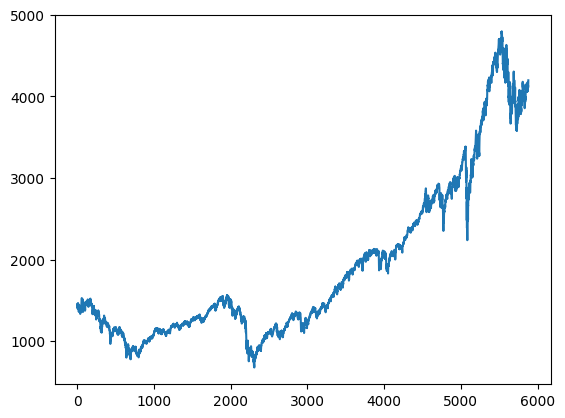

In [97]:
df1=df.reset_index()['Close']
plt.plot(df1)

In [98]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [99]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [100]:
training_size,test_size

(3822, 2059)

In [101]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [102]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [103]:
print(X_train.shape), print(y_train.shape)

(3721, 100)
(3721,)


(None, None)

In [104]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [105]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [107]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

62/62 [==============================] - 1s 13ms/step


In [108]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [109]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1332.2074067519432

In [110]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

3184.4160414865746

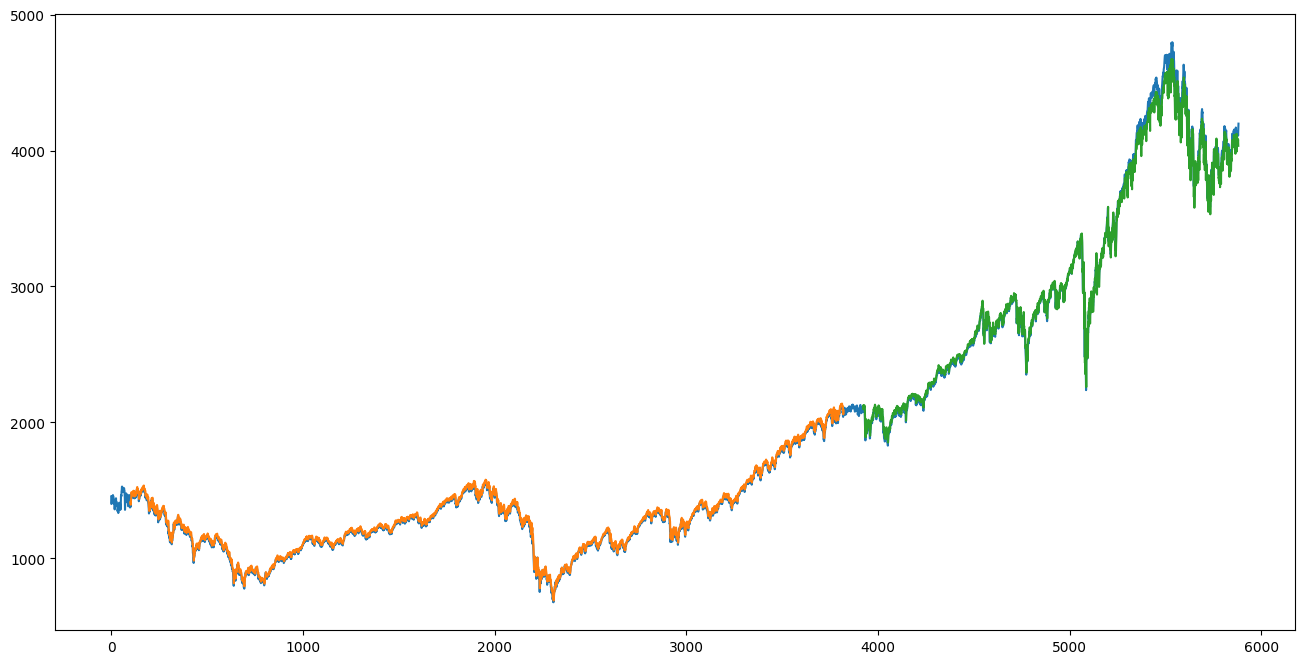

In [111]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [116]:
len(test_data)

2059

In [117]:
x_input=test_data[1959:].reshape(1,-1)
x_input.shape

(1, 100)

In [118]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [119]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1


In [120]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [121]:
len(df1)

5881

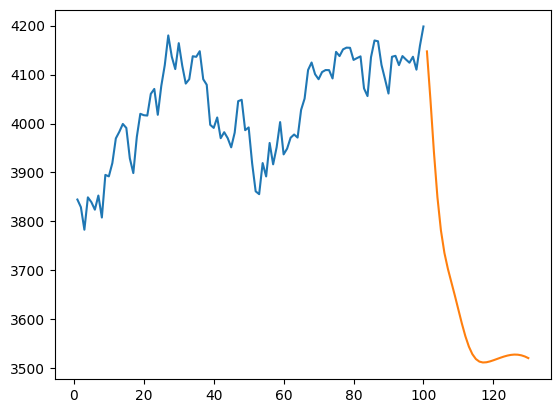

In [123]:
plt.plot(day_new,scaler.inverse_transform(df1[5781:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [146]:
predictions = scaler.inverse_transform(lst_output)
array = np.array((predictions))
df4 = pd.DataFrame(array, columns=["Price"])
df4['Price'] = df4['Price'].round(2)
df4

,Price
0,4147.21
1,4049.01
2,3941.82
3,3849.78
4,3781.99
5,3735.87
6,3703.21
7,3675.77
8,3648.46
9,3619.96


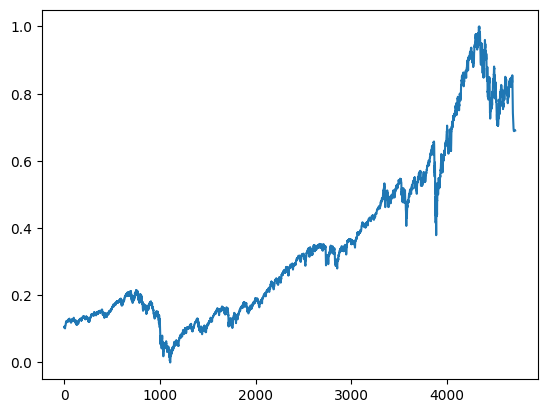

In [126]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])